# Mô tả các Nhóm Đặc Trưng Luồng Mạng (Network Flow Features)

## Nhóm 1: Thông tin cơ bản về luồng mạng (Network Flow Information)
- **id.orig_p**: Cổng nguồn (source port) của luồng mạng.  
- **id.resp_p**: Cổng đích (destination port) của luồng mạng.  
- **proto**: Giao thức mạng được sử dụng (ví dụ: TCP, UDP).  
- **service**: Dịch vụ liên quan đến luồng mạng (ví dụ: MQTT, HTTP, hoặc "-").  
- **flow_duration**: Thời gian tồn tại của luồng mạng (tính bằng giây).  

## Nhóm 2: Thống kê gói tin (Packet Statistics)
- **fwd_pkts_tot**: Tổng số gói tin từ nguồn đến đích (forward).  
- **bwd_pkts_tot**: Tổng số gói tin từ đích đến nguồn (backward).  
- **fwd_data_pkts_tot**: Gói tin chứa dữ liệu từ nguồn đến đích.  
- **bwd_data_pkts_tot**: Gói tin chứa dữ liệu từ đích đến nguồn.  
- **fwd_pkts_per_sec**: Tốc độ forward packets mỗi giây.  
- **bwd_pkts_per_sec**: Tốc độ backward packets mỗi giây.  
- **flow_pkts_per_sec**: Tổng tốc độ gói tin mỗi giây.  
- **down_up_ratio**: Tỷ lệ giữa gói tin backward và forward.  

## Nhóm 3: Kích thước tiêu đề gói tin (Header Size Statistics)
- **fwd_header_size_tot**, **min**, **max**: Tổng, nhỏ nhất, lớn nhất kích thước tiêu đề gói forward.  
- **bwd_header_size_tot**, **min**, **max**: Tổng, nhỏ nhất, lớn nhất kích thước tiêu đề gói backward.  

## Nhóm 4: Cờ TCP (TCP Flags)
- **flow_FIN_flag_count**, **SYN**, **RST**, **ACK**, **CWR**, **ECE**: Số lần xuất hiện các cờ FIN, SYN, RST, ACK, CWR, ECE trong toàn bộ luồng.  
- **fwd_PSH_flag_count**, **fwd_URG_flag_count**: Số lần xuất hiện cờ PSH, URG trong forward packets.  
- **bwd_PSH_flag_count**, **bwd_URG_flag_count**: Số lần xuất hiện cờ PSH, URG trong backward packets.  

## Nhóm 5: Thống kê tải trọng gói tin (Payload Statistics)
- **fwd_pkts_payload** (min, max, tot, avg, std): Kích thước tải trọng gói tin forward.  
- **bwd_pkts_payload** (min, max, tot, avg, std): Kích thước tải trọng gói tin backward.  
- **flow_pkts_payload** (min, max, tot, avg, std): Kích thước tải trọng toàn bộ luồng.  

## Nhóm 6: Thống kê thời gian giữa các gói tin (Inter-Arrival Time Statistics)
- **fwd_iat** (min, max, tot, avg, std): Thống kê thời gian giữa các gói tin forward.  
- **bwd_iat** (min, max, tot, avg, std): Thống kê thời gian giữa các gói tin backward.  
- **flow_iat** (min, max, tot, avg, std): Thống kê thời gian giữa các gói tin bất kỳ.  

## Nhóm 7: Thống kê luồng phụ (Subflow Statistics)
- **fwd_subflow_pkts**, **bwd_subflow_pkts**: Số gói tin trung bình mỗi subflow forward/backward.  
- **fwd_subflow_bytes**, **bwd_subflow_bytes**: Số byte trung bình mỗi subflow forward/backward.  

## Nhóm 8: Thống kê khối dữ liệu (Bulk Statistics)
- **fwd_bulk_bytes**, **fwd_bulk_packets**, **fwd_bulk_rate**: Tổng byte, gói tin, tốc độ khối dữ liệu forward.  
- **bwd_bulk_bytes**, **bwd_bulk_packets**, **bwd_bulk_rate**: Tổng byte, gói tin, tốc độ khối dữ liệu backward.  

## Nhóm 9: Thống kê thời gian hoạt động và nhàn rỗi (Active/Idle Statistics)
- **active** (min, max, tot, avg, std): Thời gian hoạt động của luồng.  
- **idle** (min, max, tot, avg, std): Thời gian nhàn rỗi của luồng.  

## Nhóm 10: Kích thước cửa sổ TCP (TCP Window Size)
- **fwd_init_window_size**, **bwd_init_window_size**: Kích thước cửa sổ ban đầu của gói forward/backward.  
- **fwd_last_window_size**: Kích thước cửa sổ cuối cùng của gói forward.  

## Nhóm 11: Nhãn tấn công (Attack Label)
- **Attack_type**: Loại tấn công mạng hoặc hành vi của luồng (ví dụ: `MQTT_Publish`, `DOS_SYN_Hping`).


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import Preprocessing
import DataProcessing
import model
import utils
data = Preprocessing.load_data('data/rt_iot2022', target_col='Attack_type')

In [2]:
print(data['Attack_type'])
X = data.drop('Attack_type', axis=1)
y = data['Attack_type'] 

0                MQTT_Publish
1                MQTT_Publish
2                MQTT_Publish
3                MQTT_Publish
4                MQTT_Publish
                 ...         
123112    NMAP_XMAS_TREE_SCAN
123113    NMAP_XMAS_TREE_SCAN
123114    NMAP_XMAS_TREE_SCAN
123115    NMAP_XMAS_TREE_SCAN
123116    NMAP_XMAS_TREE_SCAN
Name: Attack_type, Length: 123117, dtype: object


In [3]:
Preprocessing.check_types(data,"object")

proto
service
Attack_type


In [4]:
data = Preprocessing.delete_columns(data, ['service'])
data = Preprocessing.one_hot_encode(data, ['proto'])
data = Preprocessing.label_encode(data, ['Attack_type'])
print(data.head(5))

   Unnamed: 0  id.orig_p  id.resp_p  flow_duration  fwd_pkts_tot  \
0           0      38667       1883      32.011598             9   
1           1      51143       1883      31.883584             9   
2           2      44761       1883      32.124053             9   
3           3      60893       1883      31.961063             9   
4           4      51087       1883      31.902362             9   

   bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  \
0             5                  3                  3          0.281148   
1             5                  3                  3          0.282277   
2             5                  3                  3          0.280164   
3             5                  3                  3          0.281593   
4             5                  3                  3          0.282111   

   bwd_pkts_per_sec  ...      idle.max      idle.tot      idle.avg  idle.std  \
0          0.156193  ...  2.972918e+07  2.972918e+07  2.9729

In [5]:
X, y = data.drop('Attack_type', axis=1), data['Attack_type']
X_balanced, y_balanced = Preprocessing.apply_smote(X, y)
X, X_test, y, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

c:\Users\QUIN\Desktop\PPNCKH\DataProcessing.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')


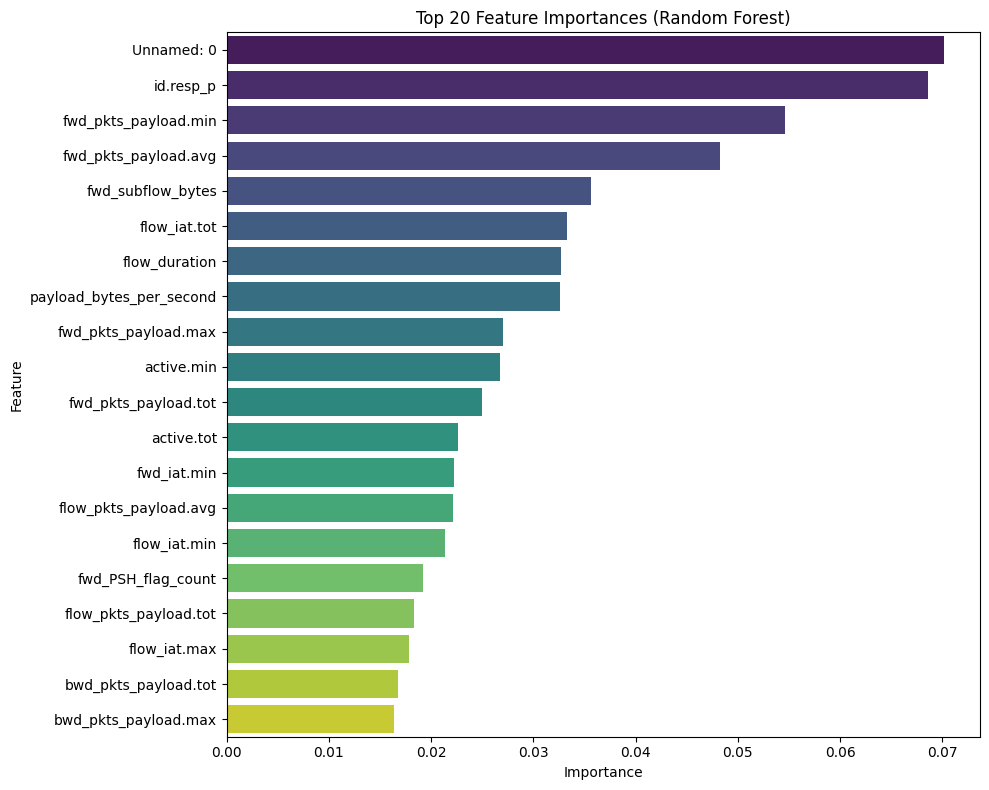

In [7]:
# Xử lý dữ liệuliệu
list = DataProcessing.select_feature(X_train, y_train)

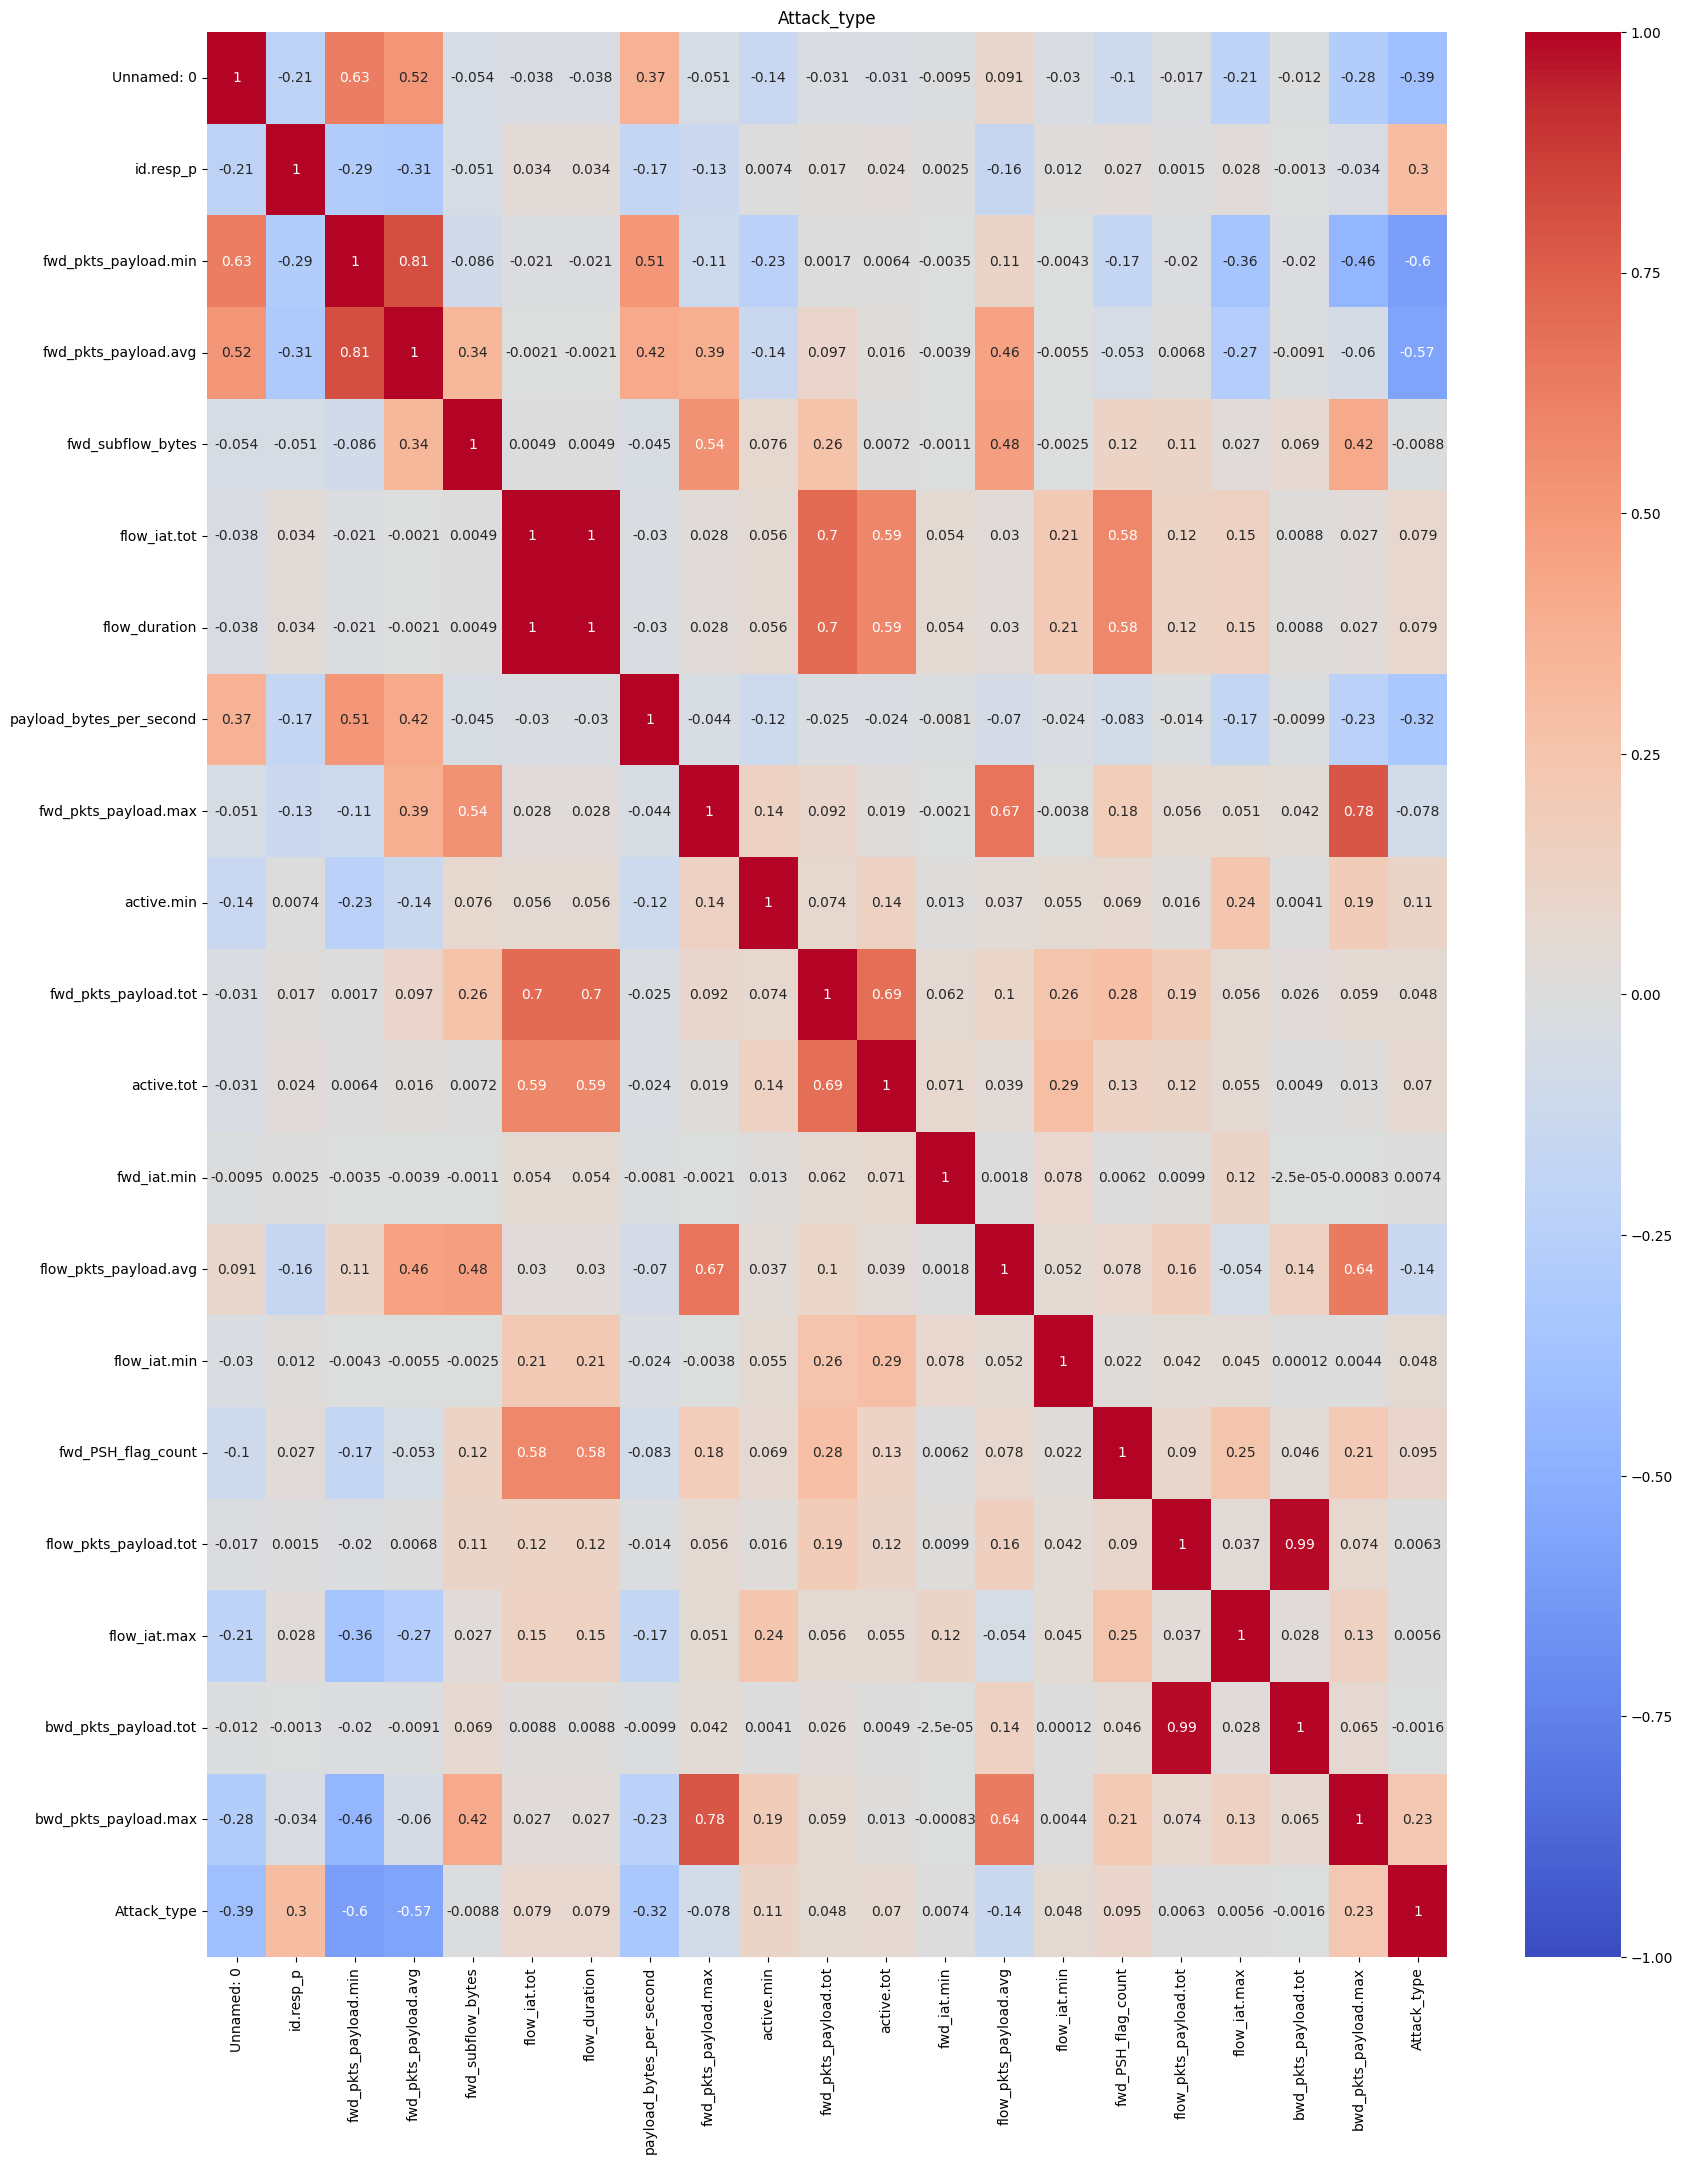

In [8]:
Preprocessing.plot_heatmap(X_train[list['Feature']], y_train,'Attack_type')

In [9]:
df_reduced, dropped_columns = DataProcessing.remove_highly_correlated_columns(X_train[list['Feature']], threshold=0.8)

Các cột bị loại bỏ: ['bwd_pkts_payload.tot', 'fwd_pkts_payload.avg', 'flow_duration']


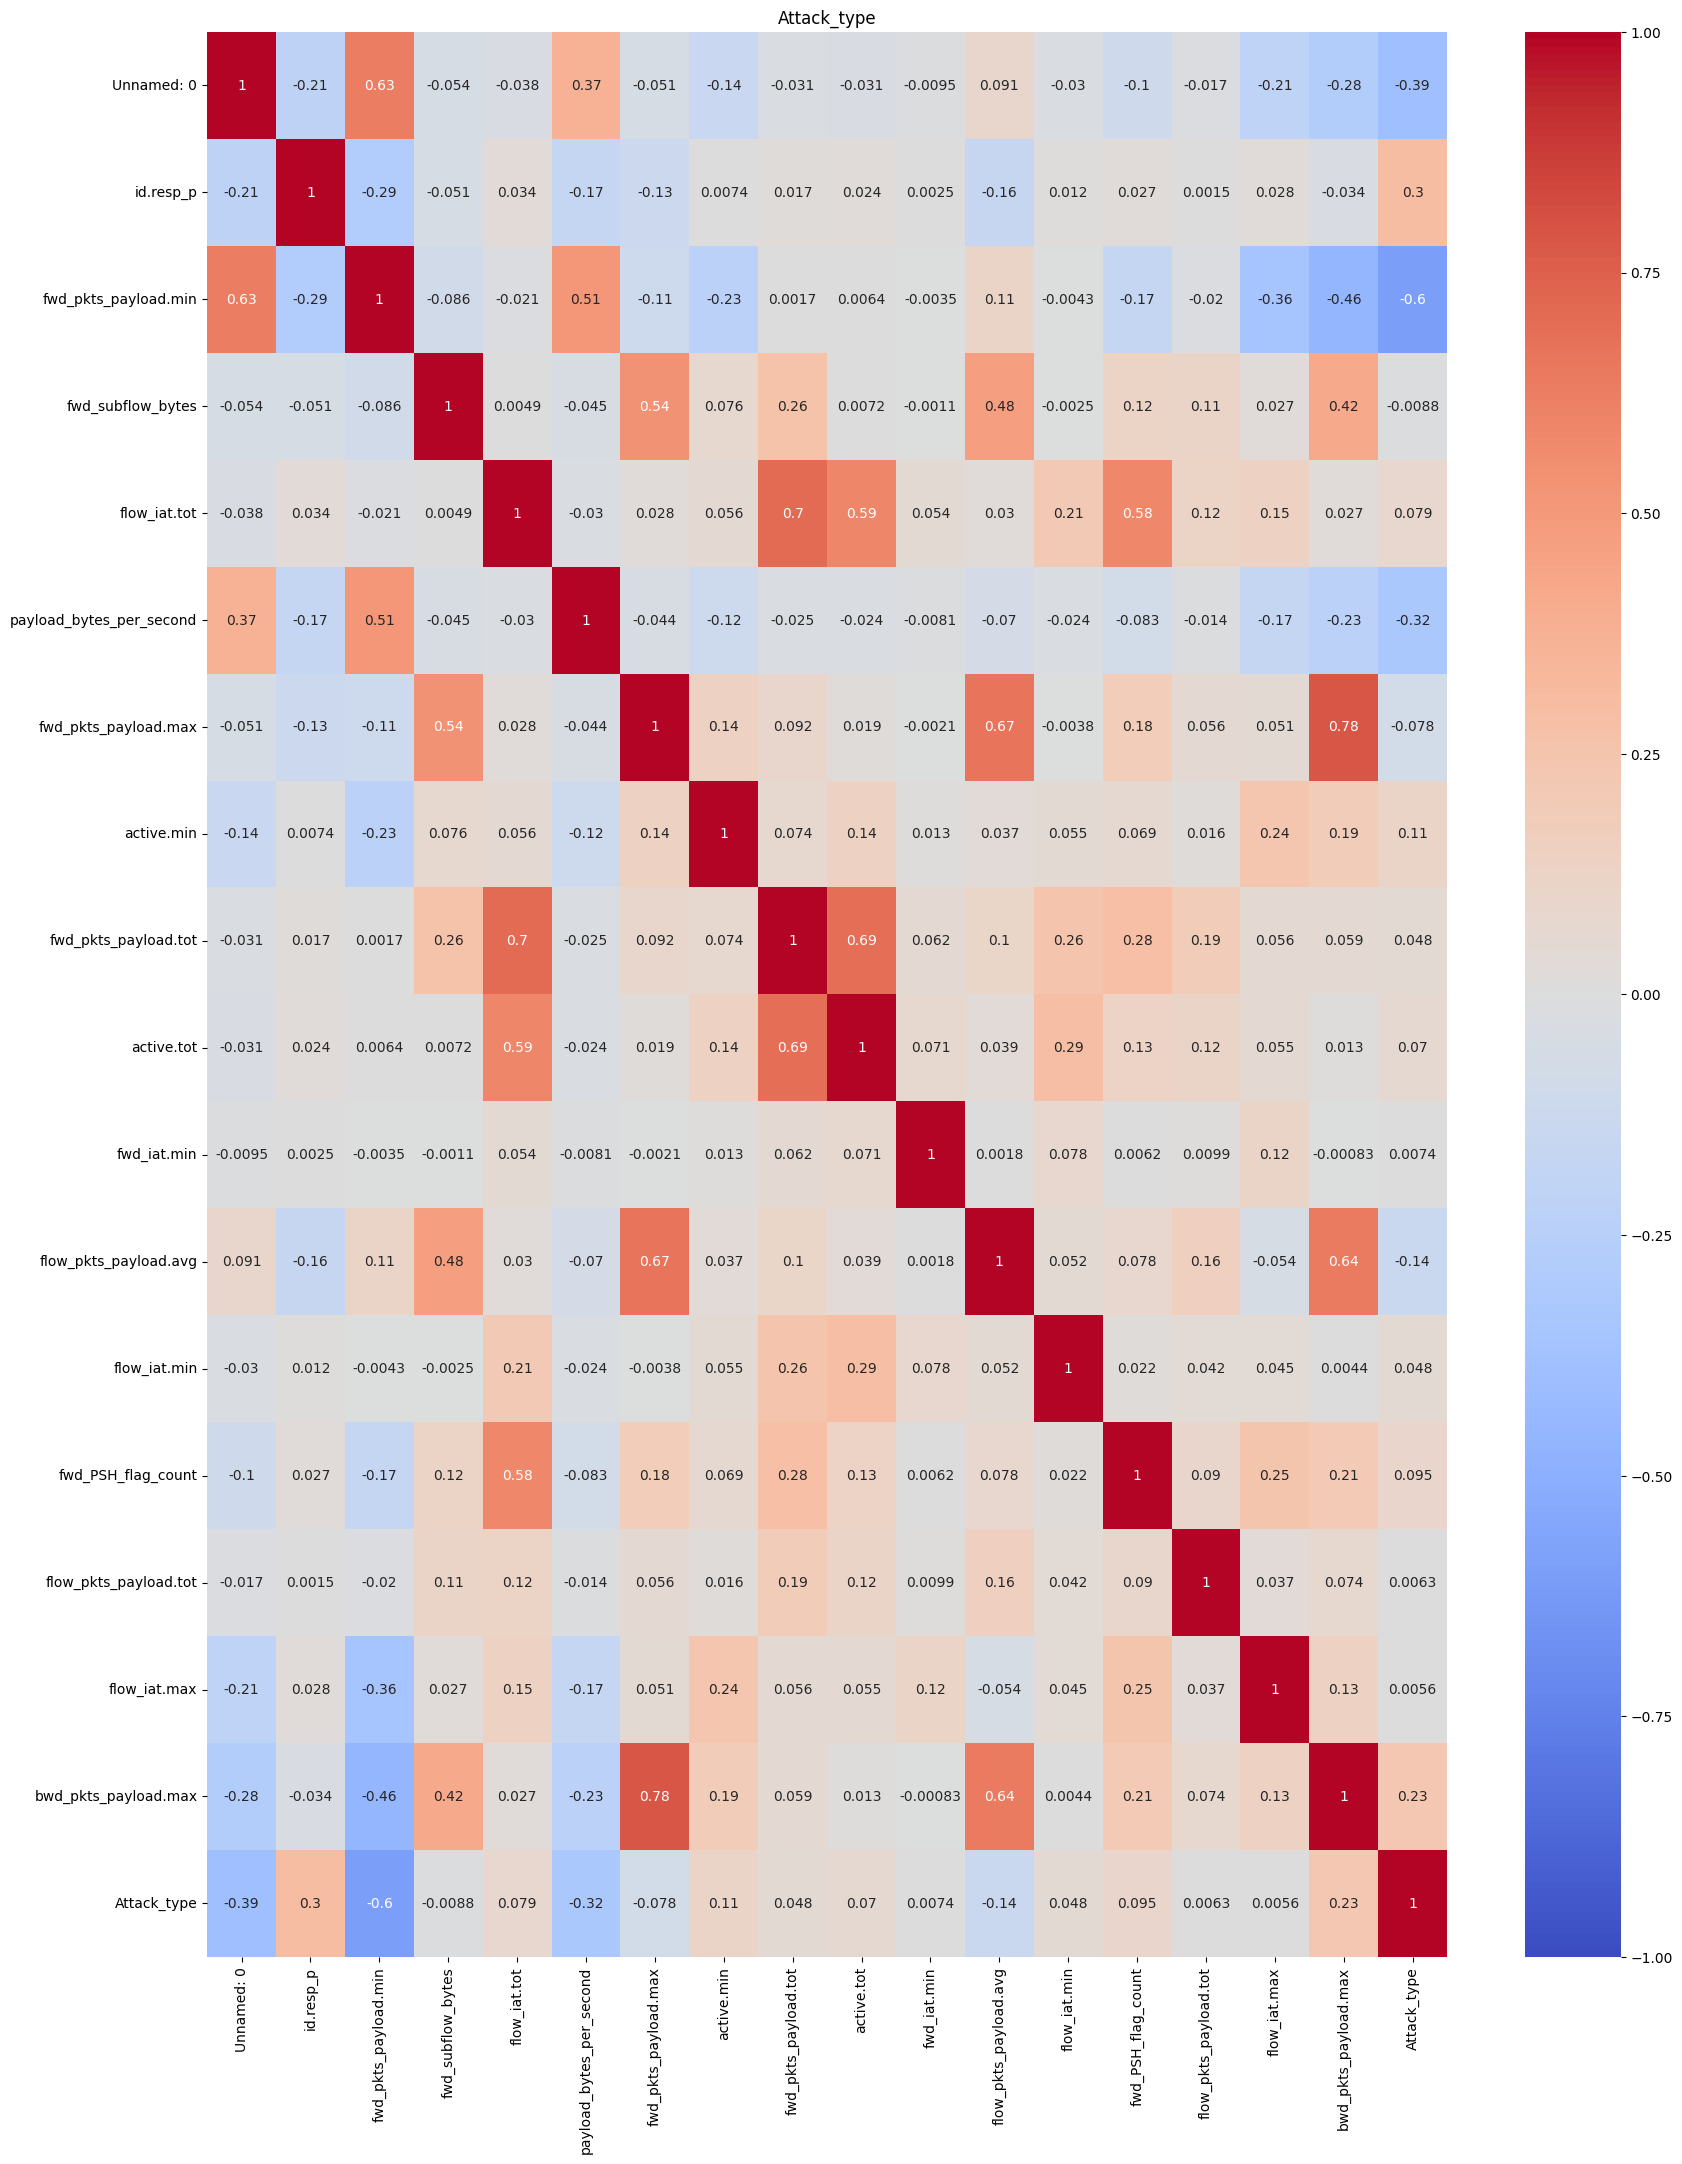

In [10]:
Preprocessing.plot_heatmap(X_train[list['Feature']].drop(dropped_columns, axis=1), y_train,'Attack_type')

In [11]:
model_svc_k_rbf = model.SVM(X_train, y_train,C=1.0, kernel='rbf', gamma='scale')
model_svc_k_rbf_predict = model_svc_k_rbf.predict(X_test)
utils.report(model_svc_k_rbf_predict, y_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.07      0.97      0.13       111
           1       0.51      0.60      0.55       348
           2       0.88      1.00      0.94     16716
           3       0.91      0.96      0.93       838
           4       0.61      0.53      0.57       439
           5       0.00      0.00      0.00         0
           6       1.00      0.06      0.11      7704
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.22      0.86      0.35        97

    accuracy                           0.71     26253
   macro avg       0.35      0.41      0.30     26253
weighted avg       0.90      0.71      0.68     26253

Confusion Matrix:
 [[  108     0     0     1     0     0     0     0     0     0     1     1]
 [   95   210  

c:\Users\QUIN\anaconda3\envs\PPNKCH\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\QUIN\anaconda3\envs\PPNKCH\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\QUIN\anaconda3\envs\PPNKCH\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
# 👉 4. Khởi tạo và huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=100,class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# 👉 5. Dự đoán
y_pred = rf_model.predict(X_test)

# 👉 6. Đánh giá
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1570
           1       1.00      1.00      1.00       413
           2       1.00      1.00      1.00     18898
           3       1.00      1.00      1.00       882
           4       1.00      1.00      1.00       384
           5       1.00      1.00      1.00       398
           6       1.00      1.00      1.00       433
           7       1.00      1.00      1.00       380
           8       0.99      0.99      0.99       501
           9       1.00      1.00      1.00       404
          10       0.99      0.99      0.99      1606
          11       0.99      0.99      0.99       384

    accuracy                           1.00     26253
   macro avg       1.00      1.00      1.00     26253
weighted avg       1.00      1.00      1.00     26253

Confusion Matrix:
 [[ 1561     0     0     0     1     0     0     1     0     0     7     0]
 [    0   412  

In [13]:
# print("Classification Report:\n", classification_report(y_test, y_pred))
print(y_test.value_counts())
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Attack_type
2     18898
10     1606
0      1570
3       882
8       501
6       433
1       413
9       404
5       398
11      384
4       384
7       380
Name: count, dtype: int64
Confusion Matrix:
 [[ 1561     0     0     0     1     0     0     1     0     0     7     0]
 [    0   412     0     0     0     0     0     0     0     0     0     1]
 [    0     0 18898     0     0     0     0     0     0     0     0     0]
 [    1     0     0   881     0     0     0     0     0     0     0     0]
 [    1     0     0     0   383     0     0     0     0     0     0     0]
 [    0     0     0     0     0   398     0     0     0     0     0     0]
 [    0     0     0     0     0     0   433     0     0     0     0     0]
 [    0     0     0     0     0     0     0   380     0     0     0     0]
 [    2     0     0     0     0     0     0     0   497     0     2     0]
 [    0     0     0     0     0     0     0     0     0   404     0     0]
 [   18     0     0     0     0     0     0     0

In [14]:
# # kiểm tra hiệu suất
# from sklearn.svm import SVC
# svm = SVC(kernel='linear')
# svm.fit(X_train[list['Feature']].drop(dropped_columns, axis=1), y_train)

# X_test_selected_reduced = X_test.drop(columns=X_train[list['Feature']].drop(dropped_columns, axis=1).columns, errors='ignore')
# accuracy = svm.score(X_test_selected_reduced, y_test)
# print(f"Accuracy on test set after feature reduction: {accuracy:.4f}")

In [15]:
# #kiểm tra nhãn dạng categorycal
# categorical_columns = data.select_dtypes(include=['object', 'category']).columns
# print(f"Các cột categorical: {list(categorical_columns)}")
# print(f"Số lượng cột categorical: {len(categorical_columns)}")
# for col in categorical_columns:
#     print(f"\nCột '{col}':")
#     print(f"Giá trị duy nhất: {data[col].unique()}")
#     print(f"Số lượng giá trị duy nhất: {data[col].nunique()}")
# #kiểm tra số lượng '-'.
# print(data['service'].value_counts()) # có ther

In [16]:
#Kiểm tra giá trị null nào không?

In [17]:
#drop cột service
# data.drop(columns=['service'], inplace=True)

In [18]:
# # one-hot encoding cho cột categorical
# from sklearn.preprocessing import OneHotEncoder

# # 2. Tạo ví dụ DataFrame
# df  = data

# # 3. Xác định cột cần one-hot encode
# categorical_cols = ['proto']

# # 4. Khởi tạo OneHotEncoder
# encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')


# # 5. Fit và transform dữ liệu
# encoded_array = encoder.fit_transform(df[categorical_cols])

# # 6. Lấy tên cột mới sau khi encode
# encoded_col_names = encoder.get_feature_names_out(categorical_cols)

# # 7. Tạo DataFrame từ mảng đã encode
# encoded_df = pd.DataFrame(encoded_array, columns=encoded_col_names)

# # 8. Bỏ các cột cũ & ghép với cột encode mới
# df_encoded = pd.concat([
#     df.drop(columns=categorical_cols).reset_index(drop=True),
#     encoded_df.reset_index(drop=True)
# ], axis=1)

# # 9. In kết quả
# data = df_encoded

In [19]:
# from sklearn.preprocessing import LabelEncoder
# import pandas as pd

# def label_encode_column(df, column_name):
#     if column_name not in df.columns:
#         raise ValueError(f"Cột '{column_name}' không tồn tại trong DataFrame")
    
#     encoder = LabelEncoder()
    
#     df[column_name] = encoder.fit_transform(df[column_name])
    
#     return df, encoder
# data, encoder = label_encode_column(data, 'Attack_type')
# print(encoder.classes_)


In [20]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# # Tính ma trận tương quan
# corr_matrix = data.corr(numeric_only=True)
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
# plt.title("Correlation Matrix (without Attack_type)")
# plt.show()


In [21]:
# import pandas as pd
# def remove_highly_correlated_columns(df, threshold=0.8, target_column=None):
#     # Tính ma trận tương quan
#     corr_matrix = df.corr().abs()  # Lấy giá trị tuyệt đối để xem xét cả tương quan âm
    
#     # Tạo một tập để lưu các cột cần loại bỏ
#     to_drop = set()
    
#     # Duyệt qua ma trận tương quan
#     for i in range(len(corr_matrix.columns)):
#         for j in range(i + 1, len(corr_matrix.columns)):
#             if corr_matrix.iloc[i, j] >= threshold:
#                 colname_i = corr_matrix.columns[i]
#                 colname_j = corr_matrix.columns[j]
                
#                 # Không loại bỏ cột mục tiêu
#                 if target_column and (colname_i == target_column or colname_j == target_column):
#                     continue
                
#                 # Loại bỏ cột có tổng tương quan lớn hơn với các cột khác
#                 if colname_j not in to_drop:
#                     to_drop.add(colname_j)
    
#     # Loại bỏ các cột
#     df_reduced = df.drop(columns=to_drop)
#     dropped_columns = list(to_drop)
    
#     print(f"Các cột bị loại bỏ: {dropped_columns}")
    
#     return df_reduced, dropped_columns
# df_reduced, dropped_columns = remove_highly_correlated_columns(data, threshold=0.8, target_column='attack_type')
    
# print("\nDataFrame sau khi loại bỏ:")
# print(df_reduced)
# print("\nDanh sách các cột bị loại bỏ:")
# print(dropped_columns)


In [22]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# # Tính ma trận tương quan
# corr_matrix = df_reduced.corr(numeric_only=True)
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
# plt.title("Correlation Matrix (without Attack_type)")
# plt.show()

In [23]:
# # Vẽ biểu đồ phân phối nhãn
# plt.figure(figsize=(10, 6))
# print(data['Attack_type'].value_counts())
# data['Attack_type'].value_counts().plot(kind='bar')
# plt.title('Phân phối các lớp trong RT-IoT2022')
# plt.xlabel('Nhãn')
# plt.ylabel('Số lượng')
# plt.xticks(rotation=45)
# plt.show()

In [24]:
# # Kiểm tra giá trị thiếu
# print("\nGiá trị thiếu:")
# print(data.isnull().sum())

In [25]:
# # 2. Xử lý dữ liệu
# # 2.1. Xử lý giá trị thiếu
# numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
# data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())
# print("\nGiá trị thiếu sau khi xử lý:")
# print(data.isnull().sum())

# # 2.2. Chuẩn hóa đặc trưng
# X = data.drop('Attack_type', axis=1)
# y = data['Attack_type']
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [26]:

# # 2.3. Mã hóa nhãn
# encoder = LabelEncoder()
# y_encoded = encoder.fit_transform(y)
# print("\nÁnh xạ nhãn:")
# for label, encoded in zip(encoder.classes_, range(len(encoder.classes_))):
#     print(f"{label}: {encoded}")

In [27]:



# # 2.4. Xử lý mất cân bằng lớp
# smote = SMOTE(random_state=42)
# X_balanced, y_balanced = smote.fit_resample(X_scaled, y_encoded)
# print("\nPhân phối nhãn sau khi cân bằng:")
# balanced_labels = pd.Series(y_balanced).value_counts()
# for label, count in zip(encoder.classes_, balanced_labels):
#     print(f"{label}: {count}")

# # Vẽ biểu đồ phân phối nhãn sau SMOTE
# plt.figure(figsize=(10, 6))
# pd.Series(y_balanced).value_counts().plot(kind='bar')
# plt.title('Phân phối các lớp sau SMOTE')
# plt.xlabel('Nhãn (mã hóa)')
# plt.ylabel('Số lượng')
# plt.xticks(ticks=range(len(encoder.classes_)), labels=encoder.classes_, rotation=45)
# plt.show()

In [28]:
# # 3. Chia dữ liệu
# X_train, X_test, y_train, y_test = train_test_split(
#     X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
# )
# print("\nKích thước tập huấn luyện:", X_train.shape, y_train.shape)
# print("Kích thước tập kiểm tra:", X_test.shape, y_test.shape)
# print("\nPhân phối nhãn trong tập huấn luyện:")
# print(pd.Series(y_train).value_counts())
# print("\nPhân phối nhãn trong tập kiểm tra:")
# print(pd.Series(y_test).value_counts())